# What to do before running the script

## Directory structure
+ `data/`
  - `dfits_20171115052750.fits`
+ `pipelines/`
  - `utils/`
    * `__init__.py`
    * `functions.py`: user-defined functions
+ `results/`
+ `snippets/` (**current directory**)
  - `analysis_for_daisy.ipynb`: this file
+ `yaml/`
  - `pointing_params.yaml`: parameters

## Parameter setting
+ `yaml/pointing_params.yaml`
  - modify `file.output_dir` as you like

# Main

In [1]:
# standard libraries
import sys
sys.path.append("../pipelines")
import pathlib

# dependent packages
import yaml
import decode as dc
import pandas as pd
import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import aplpy

# user-defined packages
from utils.functions import makecontinuum
from utils.functions import resample_with_equal_dt
from utils.functions import detrend
from utils.functions import plot_filter_response

# style settings
plt.style.use("seaborn-dark")
plt.style.use("seaborn-muted")

In [38]:
# load DFITS and params
dfits_file = pathlib.Path("../data/dfits_20171115052750.fits") # Uranus
# dfits_file = pathlib.Path("../data/dfits_20171116125026.fits") # IRC10216
yaml_file = pathlib.Path("../yaml/pointing_params.yaml")
with open(yaml_file) as file:
    params = yaml.load(file, Loader=yaml.SafeLoader)

output_dir = pathlib.Path(params["file"]["output_dir"]).expanduser()
dpi = params["file"]["dpi"]
ch = params["loaddfits"]["ch"]

cube_fits = output_dir / "cube.fits"
cont_fits = output_dir / "cont.fits"

array = dc.io.loaddfits(dfits_file, **params["loaddfits"])
scanarray = array[array.scantype=="SCAN"]

Endtime of readout is adjusted to that of ANTENNA HDU.


In [35]:
np.unique(array.scantype)

array(['GRAD', 'JUNK', 'R', 'SCAN'], dtype='<U8')

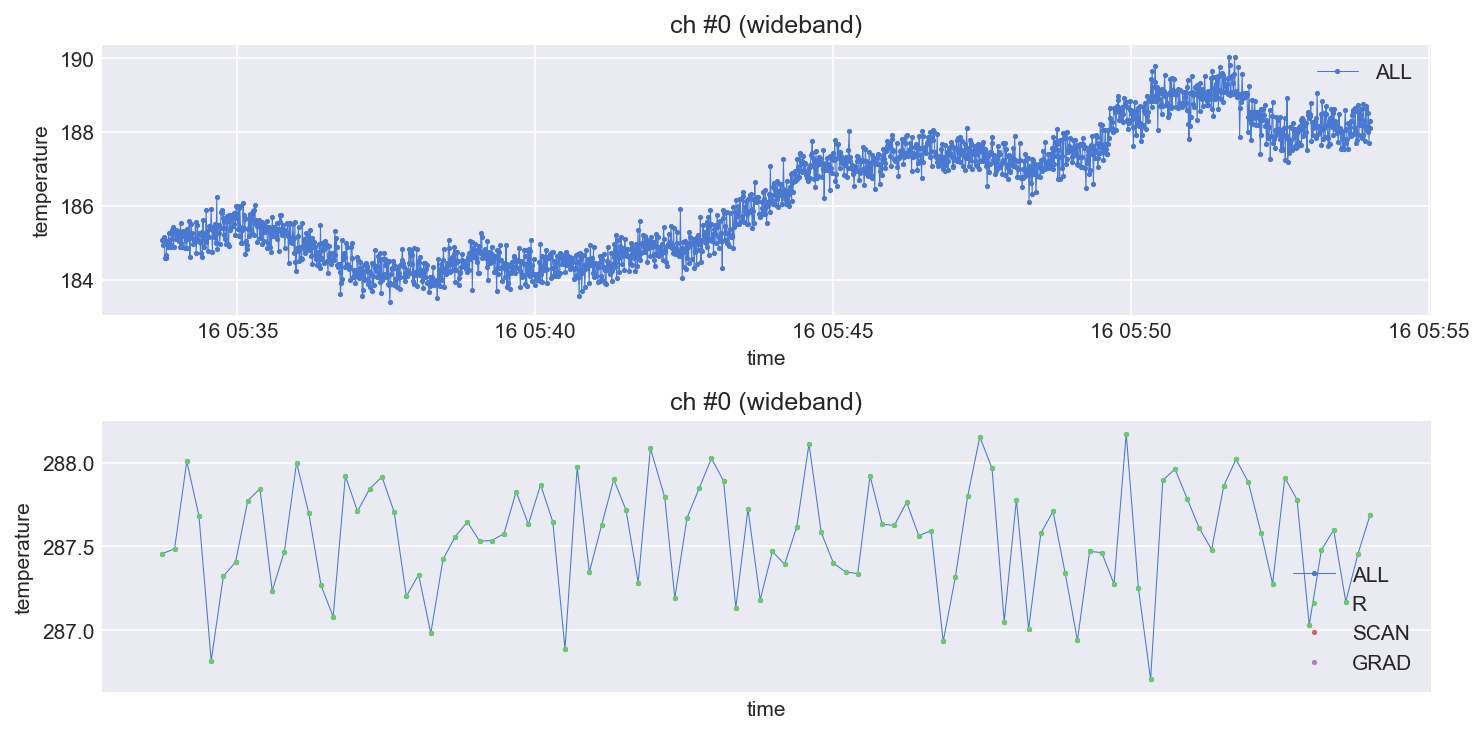

In [39]:
# plot time stream data
fig, ax = plt.subplots(2, 1, figsize=(10, 5), dpi=dpi)

plot_params0 = {"marker": ".", "markersize": 3.0, "linewidth": 0.5}
plot_params1 = {"marker": ".", "markersize": 3.0, "linestyle": "None"}

dc.plot.plot_timestream(scanarray[::100], ch, ax=ax[0], **plot_params0) # plot every 100 points

dc.plot.plot_timestream(array[2000:2100], ch, ax=ax[1], **plot_params0)
dc.plot.plot_timestream(array[2000:2100], ch, scantypes=["R"], ax=ax[1], **plot_params1)
dc.plot.plot_timestream(array[2000:2100], ch, scantypes=["SCAN"], ax=ax[1], **plot_params1)
dc.plot.plot_timestream(array[2000:2100], ch, scantypes=["GRAD"], ax=ax[1], **plot_params1)

ax[0].grid(which="both")
ax[1].grid(which="both")

fig.tight_layout()
plt.show()

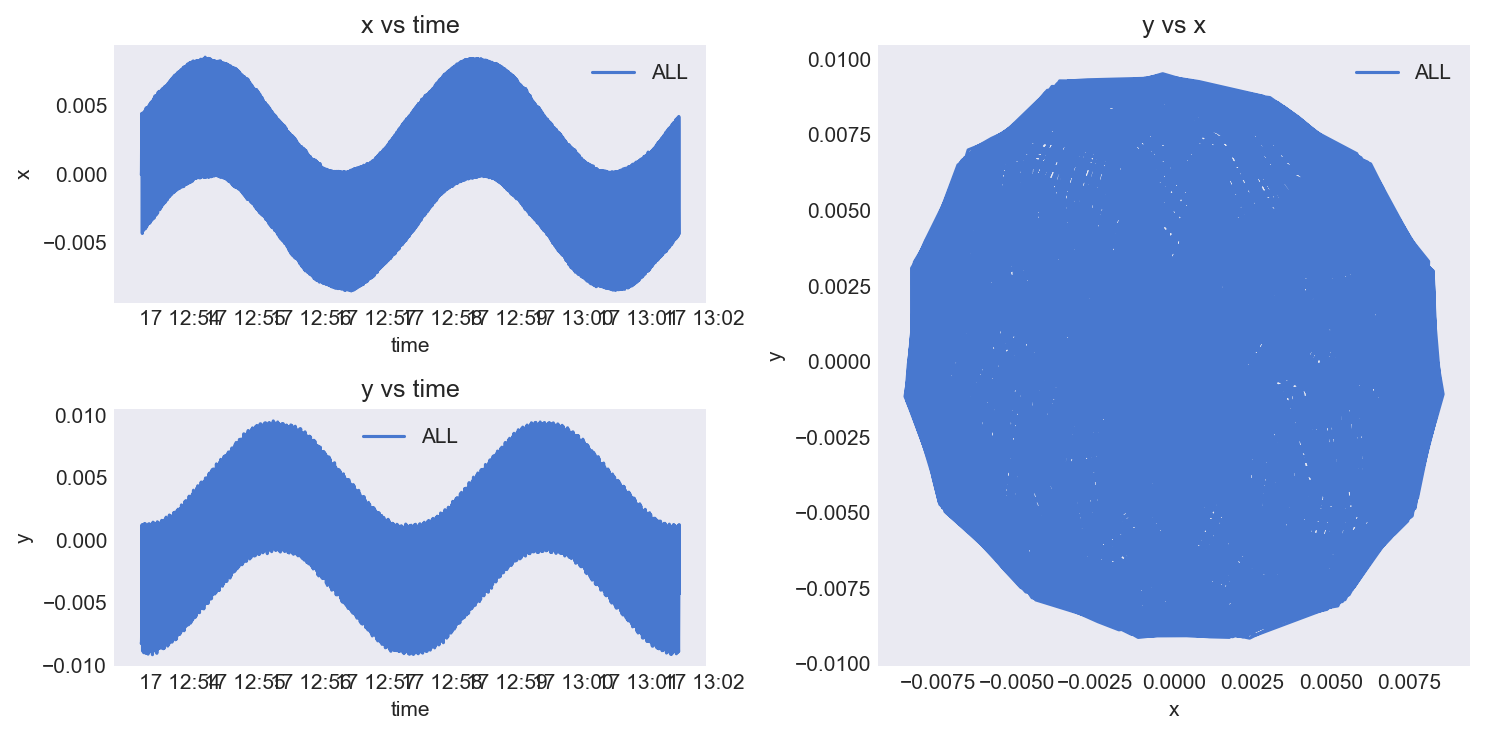

In [37]:
# plot antenna movements
fig = plt.figure(figsize=(10, 5), dpi=dpi)
gs = GridSpec(2, 2)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[1, 0], sharex=ax[0]))
ax.append(fig.add_subplot(gs[:, 1]))

# dc.plot.plot_tcoords(scanarray[:-20000], ("time", "x"), ax=ax[0])
# dc.plot.plot_tcoords(scanarray[:-20000], ("time", "y"), ax=ax[1])
# dc.plot.plot_tcoords(scanarray[:-20000], ("x", "y"), ax=ax[2])
dc.plot.plot_tcoords(scanarray, ("time", "x"), ax=ax[0])
dc.plot.plot_tcoords(scanarray, ("time", "y"), ax=ax[1])
dc.plot.plot_tcoords(scanarray, ("x", "y"), ax=ax[2])

fig.tight_layout()
fig.show()

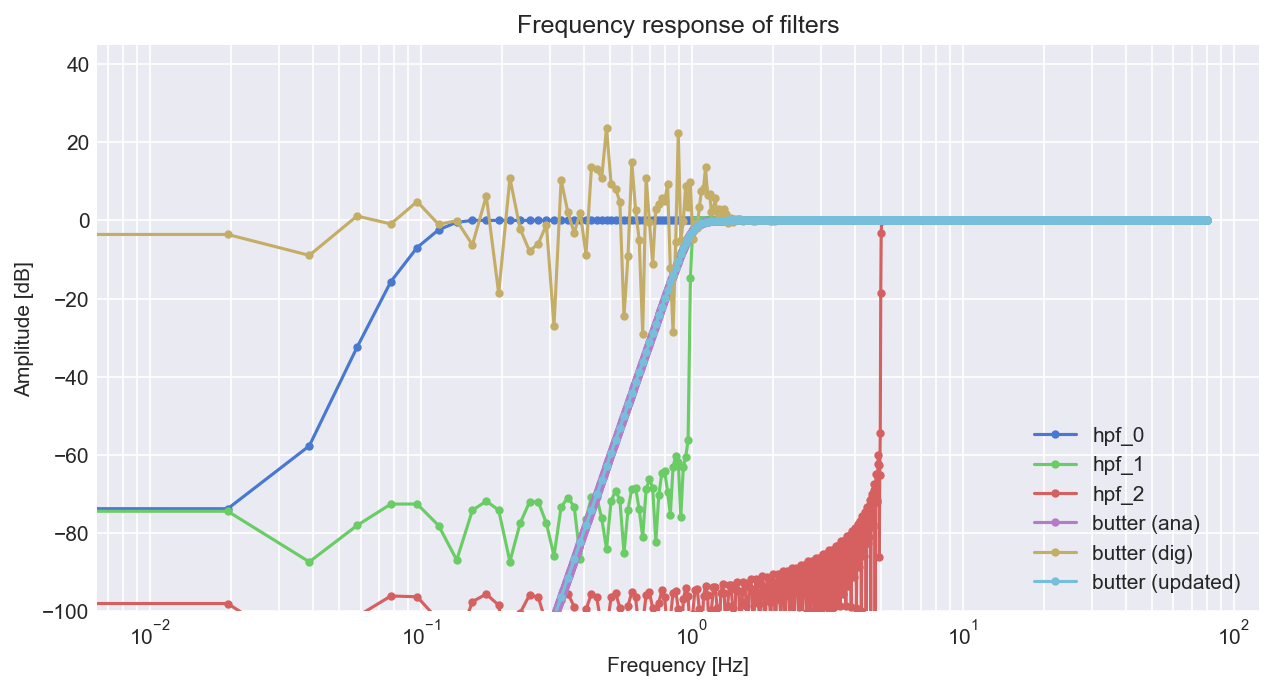

In [6]:
# interpolation
scanarray_interp = resample_with_equal_dt(scanarray)

# filter design
dt = np.unique(np.diff(scanarray_interp.time))[0] / np.timedelta64(1, "s")
fs = 1 / dt
fnyq = fs / 2
cutoff = 0.1
worN = 4096

numtaps_0 = 5001
hpf_0 = signal.firwin(numtaps=numtaps_0, cutoff=0.1/fnyq, fs=fs/fnyq, pass_zero="highpass")

numtaps_1 = 10001
hpf_1 = signal.firwin(numtaps=numtaps_1, cutoff=1.0/fnyq, fs=fs/fnyq, pass_zero="highpass")

numtaps_2 = 10001
hpf_2 = signal.firwin(numtaps=numtaps_2, cutoff=5.0/fnyq, fs=fs/fnyq, pass_zero="highpass")

n_ana = 10
b_ana, a_ana = signal.butter(N=n_ana, Wn=1.0, btype="highpass", analog=True)

n_dig = 10
b_dig, a_dig = signal.butter(N=n_dig, Wn=1.0, btype="highpass", fs=fs)

n_butter = 10
sos_but = signal.butter(N=n_butter, Wn=1.0, btype="highpass", output="sos", fs=fs)
w_but, h_but = signal.sosfreqz(sos_but, worN=worN, fs=fs)

plot_params = {"ls": "-", "marker": "o", "ms": 3.0}

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)
plot_filter_response(
    coefficients = [(hpf_0, 1), (hpf_1, 1), (hpf_2, 1), (b_ana, a_ana), (b_dig, a_dig)],
    filtertypes = ["digital", "digital", "digital", "analog", "digital"],
    worN=worN,
    fs=fs,
    **plot_params
)
ax.semilogx(w_but, 20 * np.log10(np.abs(h_but)), **plot_params)
ax.legend(["hpf_0", "hpf_1", "hpf_2", "butter (ana)", "butter (dig)", "butter (updated)"])
ax.set_ylim([-100, None])

fig.show()

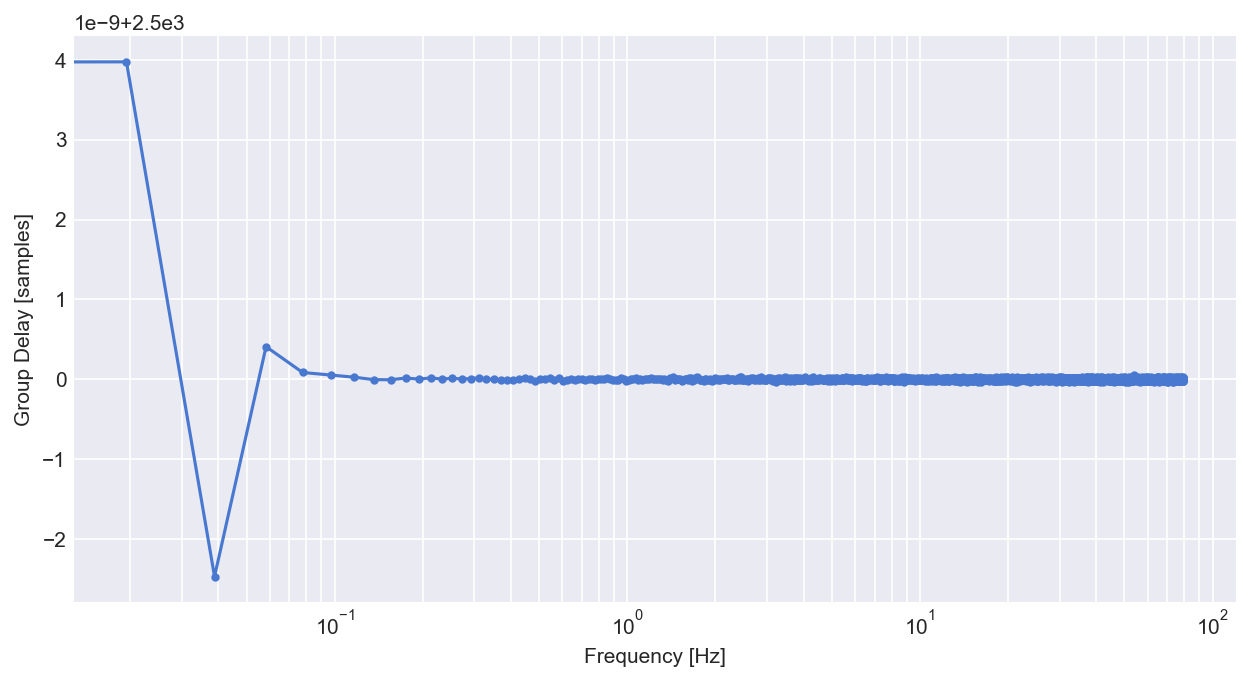

In [7]:
# calculate group delay
w, gd = signal.group_delay((hpf_0, 1), w=worN, fs=fs)
n_delay = round(np.median(gd))

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)

ax.semilogx(w, gd, **plot_params)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Group Delay [samples]")
ax.grid(which="both")

fig.show()

In [8]:
# # interpolation and filtering
# scanarray_interp = resample_with_equal_dt(scanarray)

# scanarray_interp.kidtp[[16, 18, 44, 46]] = -1
# scanarray_interp = scanarray_interp.where(scanarray_interp.kidtp == 1, drop=True)
# # scanarray_interp_sub = scanarray_interp[:, 30:36] # ch = 30-35 (for fast calculation)
# scanarray_interp_sub = scanarray_interp

# t_rel = ((scanarray_interp.time - scanarray_interp.time[0]) / np.timedelta64(1, "s")).values # time offset
# # x = detrend(scanarray_interp_sub, periodic_boundary=True)
# x = detrend(scanarray_interp_sub, periodic_boundary=False, axis=0) # equivalent to scipy.signal.detrend

# @dc.xarrayfunc
# def my_lfilter(x, b, a, axis):
#     return signal.lfilter(b, a, x, axis=axis)
# y = my_lfilter(x, hpf_0, 1, axis=0)
# # y = my_lfilter(x, b_ana, a_ana, axis=0)

In [41]:
# savgol filter
scanarray_sky = dc.xarrayfunc(signal.savgol_filter)(scanarray, 1001, 5, axis=0)
scanarray_fil = scanarray - scanarray_sky

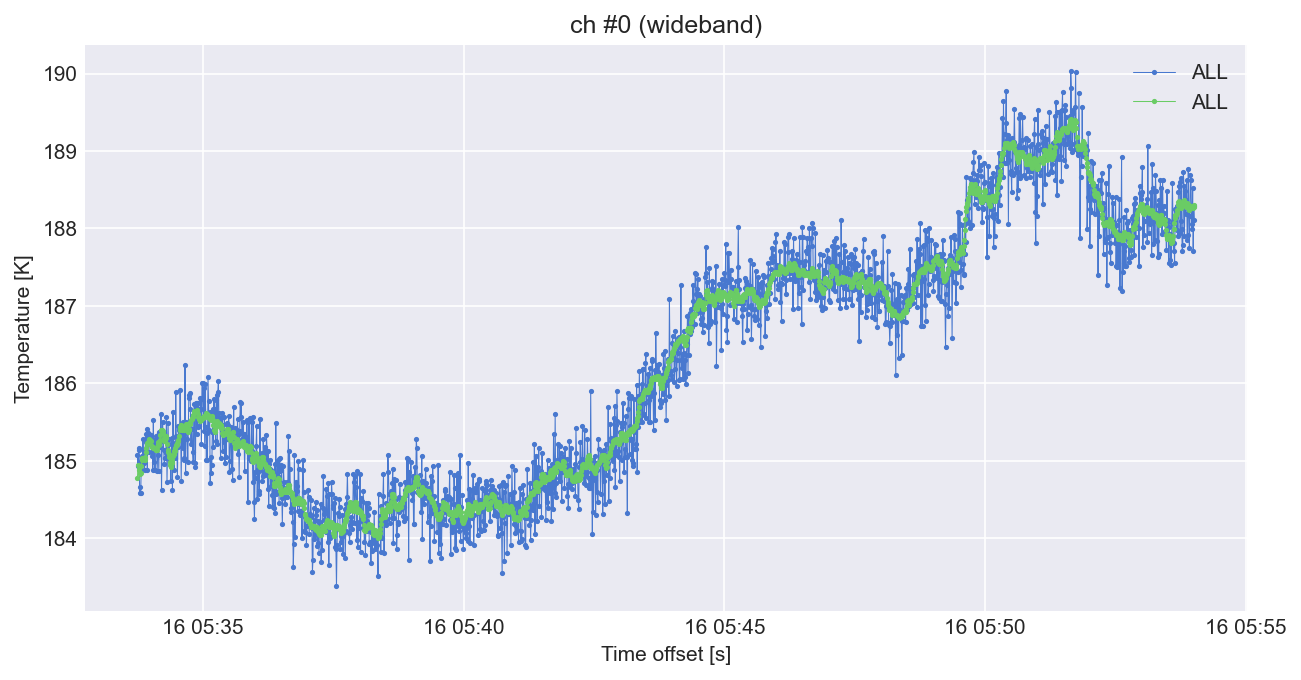

In [42]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)

# plot_params0 = {"marker": ".", "markersize": 3.0, "linewidth": 0.5}
# plot_params1 = {"marker": ".", "markersize": 3.0, "linestyle": "None"}

dc.plot.plot_timestream(scanarray[::100], ch, ax=ax, **plot_params0) # plot every 100 points
dc.plot.plot_timestream(scanarray_sky[::100], ch, ax=ax, **plot_params0) # plot every 100 points

ax.set_xlabel("Time offset [s]")
ax.set_ylabel("Temperature [K]")
ax.legend()
ax.grid(which="both")

fig.show()

In [11]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)

# t_d = t_rel[:-n_delay]
# x_d = x[:-n_delay]
# y_d = y[n_delay:]
# # t_d = t_rel
# # x_d = x
# # y_d = y

# ax.plot(t_d, x_d[:, 10], label="detrend")
# ax.plot(t_d, y_d[:, 10], label="filtered")
# ax.set_xlabel("Time offset [s]")
# ax.set_ylabel("Temperature [K]")
# ax.legend()
# ax.grid(which="both")

# fig.show()

In [12]:
# n_yd = -20000 # remove last 20000 samples (bad antenna movement)
# n_xd = n_yd + n_delay

# x_d_sub = x_d[:n_xd]
# y_d_sub = y_d[:n_yd]

# gx = params["imaging"]["gx"]
# gy = params["imaging"]["gy"]

# xmin = y_d_sub.x.min().values
# xmax = y_d_sub.x.max().values
# ymin = y_d_sub.y.min().values
# ymax = y_d_sub.y.max().values

In [43]:
##### savgol version #####
scanarray_fil.kidtp[[16, 18, 44, 46]] = -1
scanarray_fil = scanarray_fil.where(scanarray_fil.kidtp == 1, drop=True)
y_d_sub = scanarray_fil[:-20000]

gx = params["imaging"]["gx"]
gy = params["imaging"]["gy"]

xmin = y_d_sub.x.min().values
xmax = y_d_sub.x.max().values
ymin = y_d_sub.y.min().values
ymax = y_d_sub.y.max().values

In [86]:
cont_array_np = cont_array.values
cont_array_np.flags.writeable = True

In [87]:
cont_array_np[cont_array_np == 0] = np.nan

In [90]:
# make cube
cube_array = dc.tocube(y_d_sub, gx=gx, gy=gy, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
dc.io.savefits(cube_array, cube_fits, overwrite=True)

# make continuum
weight = dc.ones_like(cube_array)
cont_array = makecontinuum(cube_array, weight=weight)
# 0 => np.nan
cont_array_val = cont_array.values
cont_array_val.flags.writeable = True
cont_array_val[cont_array_val == 0] = np.nan
cont_array.values = cont_array_val
dc.io.savefits(cont_array, cont_fits, dropdeg=True, overwrite=True)

In [94]:
cont_array

<xarray.DataArray (x: 31, y: 33, ch: 1)>
array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]])
Coordinates:
  * x         (x) float64 -0.00903 -0.00843 -0.00783 ... 0.00777 0.00837 0.00897
  * y         (y) float64 -0.009695 -0.009095 -0.008495 ... 0.008905 0.009505
    masterid  (ch) int64 0
    kidid     (ch) int64 0
    kidfq     (ch) int64 0
    kidtp     (ch) int64 1
    noise     (x, y, ch) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    coordsys  <U4 'AZEL'
    datatype  <U11 'temperature'
    xref      float64 298.9
    yref      float64 32.84
    type      <U3 'dcc'
Dimensions without coordinates: ch

INFO: Auto-setting vmin to -8.443e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.038e-01 [aplpy.core]


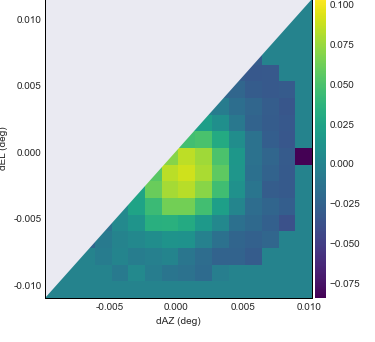

In [20]:
fig = plt.figure(figsize=(5, 5))
ax = aplpy.FITSFigure(str(cont_fits), figure=fig, subplot=(1, 1, 1))

ax.show_colorscale(cmap="viridis", stretch="linear")
ax.add_colorbar(width=0.15)

fig.tight_layout()
fig.show()

In [62]:
# n_sa = len(t_rel)
# n_td = len(t_d) # the number of samples

# freq_sa = fft.fftfreq(n_sa, d=1/fs) # frequency
# freq_td = fft.fftfreq(n_td, d=1/fs)
# f_sa = fft.fft(scanarray.values, axis=0)
# f_xd = fft.fft(x_d.values, axis=0)
# f_yd = fft.fft(y_d.values, axis=0)
# amp_sa = np.abs(f_sa / (n_sa / 2))
# amp_xd = np.abs(f_xd / (n_td / 2))
# amp_yd = np.abs(f_yd / (n_td / 2))

In [28]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)

# ax.loglog(freq_sa[1:int(n_sa / 2)], amp_sa[1:int(n_sa / 2), 10], label="scanarray")
# ax.loglog(freq_td[1:int(n_td / 2)], amp_xd[1:int(n_td / 2), 3], label="detrend")
# ax.loglog(freq_td[1:int(n_td / 2)], amp_yd[1:int(n_td / 2), 3], label="filtered")
# ax.set_xlabel("Frequency [Hz]")
# ax.set_ylabel("Amplitude")
# ax.legend()

# fig.show()

# peakyなsignalはなにか?
# IRC10216にアンテナの飛びはないか
# グリッドサイズはデフォルト2"とか?
# 環境構築のすすめ

# 外が0ではなくnanでやってみる